#  Using Markov Chain Monte Carlo Sampling to Create Models for Stellar Absolute Magnitude
## Elliot Cantor

In [480]:
import os, sys
import math
import numpy as np
import pandas as pd
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib inline
import astropy
from astropy.io.votable import parse
from astroquery.utils.tap.core import TapPlus
from astropy.stats import LombScargle
import emcee
import corner
from scipy.optimize import minimize
from astropy import units as u
from astropy.coordinates import SkyCoord
import dustmaps.sfd
from dustmaps.sfd import SFDQuery
#import mpld3
#mpld3.enable_notebook()

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 6]

import warnings
warnings.filterwarnings('ignore')

#Constants in MKS
mSun     = 1.989 * (10**30)      #sun mass
mJup     = 1.898 * (10**27)      #jupiter mass
mEarth   = 5.972 * (10**24)      #earth mass
rSun     = 695.508 * (10**6)     #sun radius
rJup     = 69.911 * (10**6)      #jupiter radius
rEarth   = 6378000               #earth radius
rNep     = (49528 / 2) * (10**3) #neptune radius
AU       = 1.496 * (10**11)      #au
G        = 6.67 * 10**(-11)      #gravitational constant
SB       = 5.67 * (10**-8)       #stephen-boltzman constant
insEarth = 1362                  #insolation flux of earth

class_seed = 42
rnd        = np.random.RandomState(class_seed)

In [360]:
gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
job = gaia.launch_job_async('''
SELECT TOP 100 * 
FROM gaiadr2.vari_rrlyrae 
WHERE pf IS NOT NULL'''
, dump_to_file=True, output_file = 'rrlyrae.vot')

r = job.get_results()

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [362]:
# Creating a list of pandas data frames for the 100 stars

phot_l = []
url_start = 'http://geadata.esac.esa.int/data-server/data?RETRIEVAL_TYPE=epoch_photometry&ID='
url_end   = '&FORMAT=CSV'
for s_id in r['source_id']:
    url = url_start + str(s_id) + url_end
    df  = pd.read_csv(url)
    phot_l.append(df)    

In [364]:
# Retrieving the mean Gmag for each star and the period estimate from the Lomb-Scargle periodogram.

gmag_means = []
periods    = []
for df in phot_l:
    gmag_means.append(np.mean(df['mag']))
    frequency, power = LombScargle(df['time'], df['mag']).autopower(minimum_frequency = 0.15, maximum_frequency = 10.0, normalization='psd', method='fast')
    periods.append(1 / frequency[np.where(power == max(power))[0][0]])

In [175]:
gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
job = gaia.launch_job_async('''
SELECT v1.pf, v1.int_average_g_error, g2.* 
FROM (SELECT * FROM gaiadr2.vari_rrlyrae WHERE pf IS NOT NULL) as v1 
JOIN gaiadr2.gaia_source as g2
USING (source_id)
WHERE (parallax_error / parallax < 0.2) 
AND (ABS(b) > 30) 
AND (parallax > 0.25)'''
, dump_to_file=True, output_file = 'crossmatch.vot')

e = job.get_results()

e[0:5]

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


pf,int_average_g_error,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url
,,,,,,yr,deg,mas,deg,mas,mas,mas,,mas.yr**-1,mas.yr**-1,mas.yr**-1,mas.yr**-1,,,,,,,,,,,,,,,,,mas,,,,mas**-2,um**-1,um**-1,,,,mas,,,,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,,mag,mag,mag,km.s**-1,km.s**-1,,K,log(cm.s**-2),'dex',,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,,
float64,float64,int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object,object
0.8320676651309765,0.0012141607329940666,1635721458409799680,Gaia DR2 4654631533876789632,4654631533876789632,502718668,2015.5,74.9400157761591,0.2733604035932282,-71.26989081181405,0.33696462393922116,1.6894774072816263,0.30216088541975844,5.591317,6.05020153987716,0.5455196368621548,0.628131711054124,0.6981791709182581,0.3272286,0.23262632,-0.10497147,-0.25516945,0.29768217,-0.17846952,-0.41671202,0.23469493,-0.12530288,0.38569498,216,0,215,1,12.117893,567.8069,2.1330096062226054,16.857222742528844,31,False,0.12917997,1.4539855359364668,0.078383153757816,0.10024075,25,18,0.6841378,0,26,False,225,508.1526859542116,5.678878027277198,89.48118,18.92338,23,349.66998261205407,18.650916066142372,18.74814,18.992243,21,369.05802063269095,13.43244388221689,27.47512,18.344183,1.4143938,0,0.64805984,0.068862915,0.57919693,--,--,0,--,--,--,VARIABLE,282.8069238916761,-34.44734416633837,312.1375913503267,-82.85625476314489,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,http://geadata.esac.esa.int/data-server/datalink/links?ID=4654631533876789632,http://geadata.esac.esa.int/data-server/data?RETRIEVAL_TYPE=epoch_photometry&ID=4654631533876789632
0.7328986984075784,0.00018942678268851196,1635721458

In [176]:
print(f'There are {len(e)} stars in my crossmatch.')

There are 468 stars in my crossmatch.


In [385]:
gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
job = gaia.launch_job_async('''
SELECT source_id, e3.r_est, e3.r_lo, e3.r_hi 
FROM (SELECT * FROM gaiadr2.vari_rrlyrae where pf IS NOT NULL) as v1 
JOIN gaiadr2.gaia_source as g2
USING (source_id)
JOIN external.gaiadr2_geometric_distance as e3
USING (source_id)
WHERE (ABS(parallax_error / parallax) < 0.2) 
AND (ABS(B) > 30) 
AND (parallax > 0.25)'''
, dump_to_file=True, output_file = 'crossmatch.vot')

f = job.get_results()

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


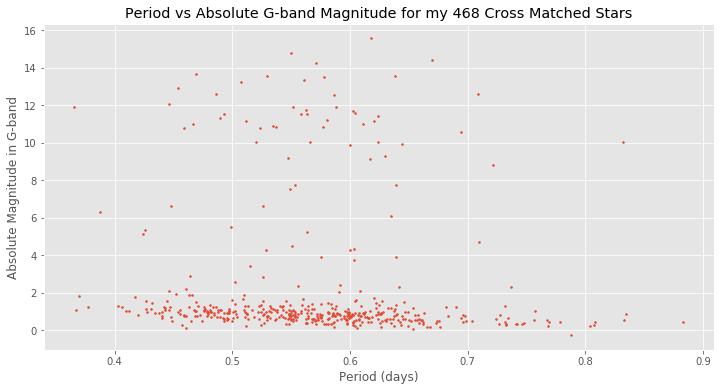

In [389]:
g_mag = e['phot_g_mean_mag']
abs_mag = -5 * np.log10(f['r_est'] / 10) + g_mag
plt.plot(e['pf'], abs_mag, '.', markersize=3)
plt.title('Period vs Absolute G-band Magnitude for my 468 Cross Matched Stars')
plt.ylabel('Absolute Magnitude in G-band')
plt.xlabel('Period (days)');

In [390]:
# Generating my u statistic
chi_squared = e['astrometric_chi2_al']
degrees_freedom = e['astrometric_n_good_obs_al'] - 5
u = np.sqrt(chi_squared / degrees_freedom)

# Using equation C1
c1 = []
for i in np.arange(0, len(e['pf'])):
    if u[i] < 1.2 * max(1, np.exp(-0.2 * (e['phot_g_mean_mag'][i] - 19.5))):
        c1.append(i)


c2 = []
for i in np.arange(0, len(e['pf'])):
     if ((e['phot_bp_rp_excess_factor'][i] > 1.0 + 0.015 * (e['bp_rp'][i])**2) and 
        (e['phot_bp_rp_excess_factor'][i] < 1.3 + 0.06 * (e['bp_rp'][i])**2)):
            c2.append(i)

good_stars = list(set(c1 + c2))
        
print(f'There were {len(e["pf"]) - len(c1)} stars filtered out using C1 and {len(e["pf"]) - len(c2)} stars filtered out using C2 when applied independently. \n The new amount of targets when using C1 and C2 together is {len(good_stars)}.')


There were 40 stars filtered out using C1 and 59 stars filtered out using C2 when applied independently. 
 The new amount of targets when using C1 and C2 together is 428.


In [392]:
new_abs_mag = abs_mag[good_stars]
new_pf = e['pf'][good_stars]
rejection_zone = 1.5 * np.percentile(new_abs_mag, 75) - np.percentile(new_abs_mag, 25)
new_ind = np.where(new_abs_mag < np.percentile(new_abs_mag, 75) + rejection_zone)[0]

In [393]:
###Error Calculating
err_lo = new_abs_mag[new_ind] - (-5 * np.log10(f['r_lo'][good_stars][new_ind] / 10) + g_mag[good_stars][new_ind])
err_hi = (-5 * np.log10(f['r_hi'][good_stars][new_ind] / 10) + g_mag[good_stars][new_ind]) - new_abs_mag[new_ind]

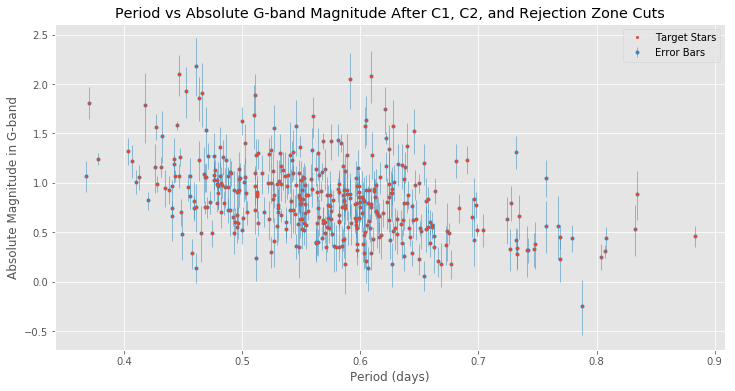

In [394]:
plt.plot(new_pf[new_ind], new_abs_mag[new_ind], '.', markersize=4, zorder= 10, label='Target Stars')
plt.errorbar(new_pf[new_ind], new_abs_mag[new_ind], xerr=None, yerr=(err_lo, err_hi), fmt = '.', elinewidth = .5, label='Error Bars')
plt.title('Period vs Absolute G-band Magnitude After C1, C2, and Rejection Zone Cuts')
plt.ylabel('Absolute Magnitude in G-band')
plt.xlabel('Period (days)')
plt.legend();

In [395]:
# guess params
a_true = -0.25
b_true = 0.75
f_true = 1.7057

def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * np.log(x) + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprior(theta):
    a, b, lnf = theta
    if -2 < a < 0 and 0 < b < 3.5 and -5.0 < lnf < 1.0:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

from scipy.optimize import minimize
nll = lambda *args: -lnlike(*args)
initial = np.array([a_true, b_true, np.log(f_true)]) + 0.1*np.random.randn(3)
soln = minimize(nll, initial, args=(new_pf[new_ind], new_abs_mag[new_ind], err_hi))
a_ml, b_ml, log_f_ml = soln.x

My priors for <b>a</b>, <b>b</b>, and likelihood <b>ln(f)</b> respectively are <b>-0.25</b>, <b>0.75</b>, and <b>0.54</b> which I picked as a rough guess from looking at the plot.

In [413]:
print(f'My estimated parameters for the model: a * np.log(x) + b, are a = {a_ml}, b = {b_ml} \nwith a log likelihood of {log_f_ml}')


My estimated parameters for the model: a * np.log(x) + b, are a = -1.0526335167266654, b = -1.0431867136330084 
with a log likelihood of -0.7856043389235929


In [397]:
def M_G(P):
    return a_ml * np.log(P) + b_ml

t = np.linspace(min(new_pf[new_ind]), max(new_pf[new_ind]), 250)
M = M_G(t)

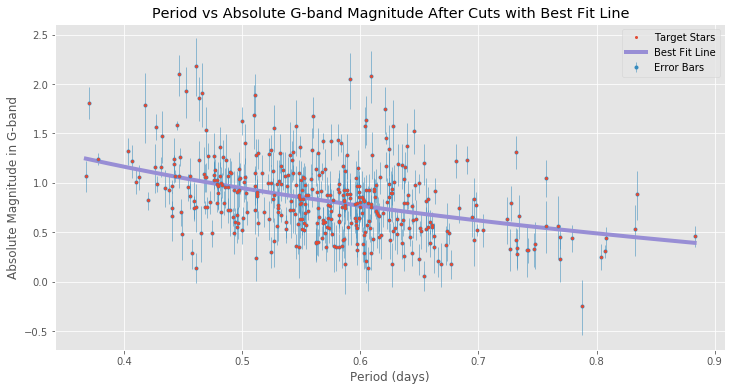

In [398]:
plt.plot(new_pf[new_ind], new_abs_mag[new_ind], '.', markersize=4, zorder= 10, label='Target Stars')
plt.errorbar(new_pf[new_ind], new_abs_mag[new_ind], xerr=None, yerr=(err_lo, err_hi), fmt = '.', elinewidth = .5, label='Error Bars')
plt.plot(t, M, linewidth=4, label='Best Fit Line')
plt.title('Period vs Absolute G-band Magnitude After Cuts with Best Fit Line')
plt.ylabel('Absolute Magnitude in G-band')
plt.xlabel('Period (days)')
plt.legend();

$\text{My likelihood function is:} 
\\ \text{ln} \ p(M_G \ | \ P, \sigma, a, b, f) \ = \ -\frac{1}{2} \sum_n{\Bigg[ \frac{({M_G}_n \ - a \ \text{ln}(P_n) \ - \ b)^2} {s_n^2} \ + \ \text{ln} \Big( 2\pi \ s_n^2 \Big) \Bigg]} \\
\text{where} \\ s_n^2 \ = \ \sigma_n^2 \ + \ f^2 \ (a \ \text{ln} (P_n) \ + b)^2$

In [399]:
pos = soln.x + 1e-4*np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(new_pf[new_ind], new_abs_mag[new_ind], err_hi))
sampler.run_mcmc(pos, 1500, progress=True)
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True);

100%|██████████| 1500/1500 [02:08<00:00, 11.68it/s]


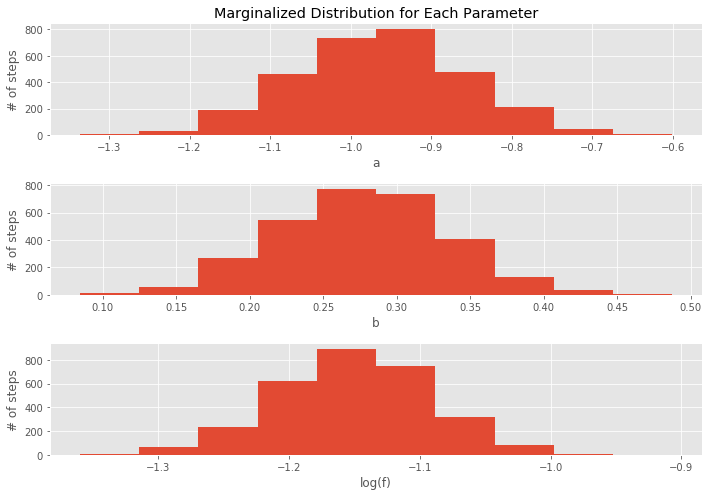

In [401]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=False)
labels = ["a", "b", "log(f)"]
for i in range(3):
    ax = axes[i]
    ax.hist(flat_samples[:, i])
    ax.set_ylabel('# of steps')
    ax.set_xlabel(labels[i])

axes[-3].set_title('Marginalized Distribution for Each Parameter')
plt.tight_layout();

Above I have the one dimensional projections of the posterior probability distributions of my parameters, in the corner plot in the next section I show the two dimensional dsitributions as well.

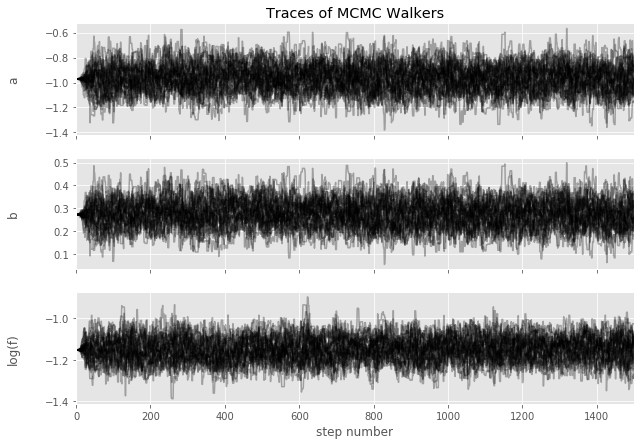

In [402]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-3].set_title('Traces of MCMC Walkers')
axes[-1].set_xlabel("step number");

I can look at the plots and rationalize that they have converged.

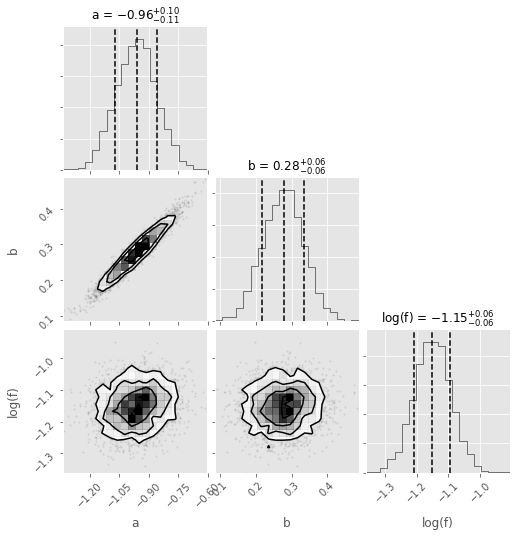

In [403]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels, truths=[a_true, b_true, np.log(f_true)],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12});

Above are all of the posterier projections for the fit.

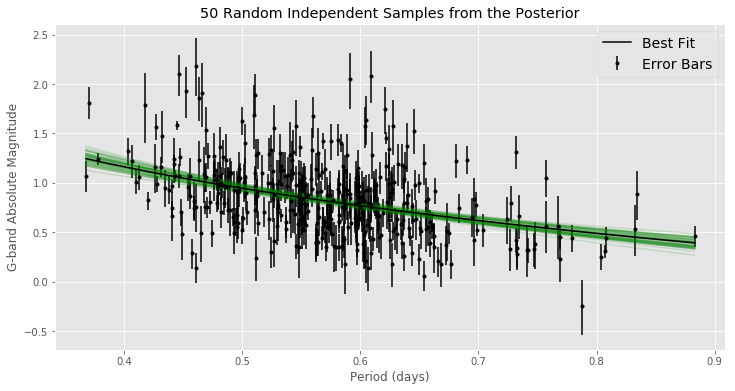

In [404]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
xl = np.array([min(new_pf[new_ind]), max(new_pf[new_ind])])

for a, b, lnf in samples[np.random.randint(len(samples), size=50)]:
    plt.plot(t, a*np.log(t)+b, color="g", alpha=0.15)

plt.errorbar(new_pf[new_ind], new_abs_mag[new_ind], yerr = (err_lo, err_hi), fmt=".k", capsize=0, label='Error Bars')
plt.plot(t, M_G(t), "k", label="Best Fit")
plt.legend(fontsize=14)
plt.xlabel("Period (days)")
plt.ylabel("G-band Absolute Magnitude")
plt.title('50 Random Independent Samples from the Posterior');

The spread does seem consistent with what I would expect from the data considering that the samples all seem to be great fits that are very close to the best fit that I calculated. Changin the bounds on my priors did help quite a bit though, especially with the b parameter.

In [405]:
gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
job = gaia.launch_job_async('''
SELECT *
FROM gaiadr2.allwise_best_neighbour as n2
JOIN (SELECT * FROM gaiadr2.vari_rrlyrae WHERE pf IS NOT NULL) as v1
USING (source_id)
JOIN gaiadr2.gaia_source as g2
USING (source_id)
INNER JOIN gaiadr1.allwise_original_valid as n1
ON n1.allwise_oid = n2.allwise_oid
JOIN external.gaiadr2_geometric_distance as e1
USING (source_id)
WHERE (parallax_error / parallax < 0.2) 
AND (ABS(b) > 30) 
AND (parallax > 0.25)
AND w2mpro IS NOT NULL'''
, dump_to_file=True, output_file = 'crossmatch.vot')

n = job.get_results()

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [448]:
w_mag = n['w2mpro']
w_abs_mag = -5 * np.log10(n['r_est'] / 10) + w_mag
# Generating my u statistic
chi_squared = n['astrometric_chi2_al']
degrees_freedom = n['astrometric_n_good_obs_al'] - 5
u = np.sqrt(chi_squared / degrees_freedom)
# Using equation C1
c1 = []
for i in np.arange(0, len(n['pf'])):
    if u[i] < 1.2 * max(1, np.exp(-0.2 * (n['phot_g_mean_mag'][i] - 19.5))):
        c1.append(i)
c2 = []
for i in np.arange(0, len(n['pf'])):
     if ((n['phot_bp_rp_excess_factor'][i] > 1.0 + 0.015 * (n['bp_rp'][i])**2) and 
        (n['phot_bp_rp_excess_factor'][i] < 1.3 + 0.06 * (n['bp_rp'][i])**2)):
            c2.append(i)
good_stars = list(set(c1 + c2))   
print(f'There were {len(n["pf"]) - len(c1)} stars filtered out using C1 and {len(n["pf"]) - len(c2)} stars filtered out using C2 when applied independently. \n The new amount of targets when using C1 and C2 together is {len(good_stars)}.')
new_w_abs_mag = w_abs_mag[good_stars]
new_pf = n['pf'][good_stars]
rejection_zone = 1.5 * np.percentile(new_w_abs_mag, 75) - np.percentile(new_w_abs_mag, 25)
new_ind = np.where(new_w_abs_mag < np.percentile(new_w_abs_mag, 75) + rejection_zone)[0]
# errors
err_lo = new_w_abs_mag[new_ind] - (-5 * np.log10(n['r_lo'][good_stars][new_ind] / 10) + w_mag[good_stars][new_ind])
err_hi = (-5 * np.log10(n['r_hi'][good_stars][new_ind] / 10) + w_mag[good_stars][new_ind]) - new_w_abs_mag[new_ind]

n = n[good_stars][new_ind]
print(f'\n\nThere are {len(n)} stars total in the WISE cross match.')
n[0:5]

There were 0 stars filtered out using C1 and 5 stars filtered out using C2 when applied independently. 
 The new amount of targets when using C1 and C2 together is 367.


There are 360 stars total in the WISE cross match.


original_ext_source_id,angular_distance,gaia_astrometric_params,allwise_oid,number_of_neighbours,number_of_mates,best_neighbour_multiplicity,p3_o,p2_o,p1_o,r21_g,best_classification,p1_o_error,peak_to_peak_bp_error,phi21_g,num_clean_epochs_bp,solution_id,int_average_rp,epoch_g,g_absorption_error,peak_to_peak_rp,phi31_g_error,epoch_bp_error,epoch_bp,epoch_rp_error,num_clean_epochs_rp,pf_error,epoch_g_error,int_average_g_error,peak_to_peak_g_error,r31_g_error,g_absorption,r31_g,phi31_g,int_average_g,peak_to_peak_bp,epoch_rp,peak_to_peak_rp_error,phi21_g_error,p3_o_error,num_clean_epochs_g,int_average_bp_error,pf,int_average_rp_error,metallicity_error,p2_o_error,r21_g_error,peak_to_peak_g,int_average_bp,metallicity,solution_id_2,designation,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,allwise_oid_2,designation_2,ra_2,dec_2,ra_error_2,dec_error_2,radec_co_error,w1mpro,w1mpro_error,w2mpro,w2mpro_error,w3mpro,w3mpro_error,w4mpro,w4mpro_error,cc_flags,ext_flag,var_flag,ph_qual,w1mjd_mean,w2mjd_mean,w3mjd_mean,w4mjd_mean,w1gmag,w1gmag_error,w2gmag,w2gmag_error,w3gmag,w3gmag_error,w4gmag,w4gmag_error,tmass_key,r_est,r_lo,r_hi,r_len,result_flag,modality_flag,source_id
,arcs,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,yr,deg,mas,deg,mas,mas,mas,,mas.yr**-1,mas.yr**-1,mas.yr**-1,mas.yr**-1,,,,,,,,,,,,,,,,,mas,,,,mas**-2,um**-1,um**-1,,,,mas,,,,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,'electron'.s**-1,'electron'.s**-1,,mag,,,mag,mag,mag,km.s**-1,km.s**-1,,K,log(cm.s**-2),'dex',,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,,,,,deg,deg,arcs,arcs,arcs,mag,mag,mag,mag,mag,mag,mag,mag,,,,,d,d,d,d,mag,mag,mag,mag,mag,mag,mag,mag,,pc,pc,pc,pc,,,
object,float64,int16,int64,int32,int16,int16,float64,float64,float64,float64,object,float64,float64,float64,int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int3

### o.

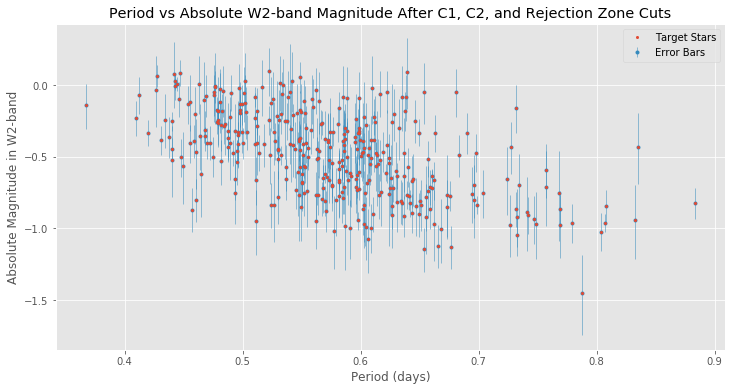

In [449]:
plt.plot(new_pf[new_ind], new_w_abs_mag[new_ind], '.', markersize=4, zorder= 10, label='Target Stars')
plt.errorbar(new_pf[new_ind], new_w_abs_mag[new_ind], xerr=None, yerr=(err_lo, err_hi), fmt = '.', elinewidth = .5, label='Error Bars')
plt.title('Period vs Absolute W2-band Magnitude After C1, C2, and Rejection Zone Cuts')
plt.ylabel('Absolute Magnitude in W2-band')
plt.xlabel('Period (days)')
plt.legend();

In [450]:
# guess params
a_true = -0.25
b_true = 0.5
f_true = .009

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * np.log(x) + b
    sigma2 = yerr**2 + model**2*np.exp(2*log_f)
    return -0.5*np.sum((y-model)**2/sigma2 + np.log(sigma2))

def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and -2.0 < b < 5.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

nll = lambda *args: -lnlike(*args)
initial = np.array([a_true, b_true, np.log(f_true)]) + 0.1*np.random.randn(3)
soln = minimize(nll, initial, args=(new_pf[new_ind], new_w_abs_mag[new_ind], err_hi))
a_ml, b_ml, log_f_ml = soln.x

My priors for <b>a</b>, <b>b</b>, and likelihood <b>ln(f)</b> respectively are <b>-0.25</b>, <b>0.5</b>, and <b>-4.71</b> which I picked as a rough guess from looking at the plot

In [451]:
print(f'My estimated parameters for the model: a * np.log(x) + b, are a = {a_ml}, b = {b_ml} \nwith a log likelihood of {log_f_ml}')

def M_W2(P):
    return a_ml * np.log(P) + b_ml

t = np.linspace(min(new_pf[new_ind]), max(new_pf[new_ind]), 250)
M = M_W2(t)

My estimated parameters for the model: a * np.log(x) + b, are a = -0.9981963876204004, b = -1.0376420457545155 
with a log likelihood of -1.0024836973942013


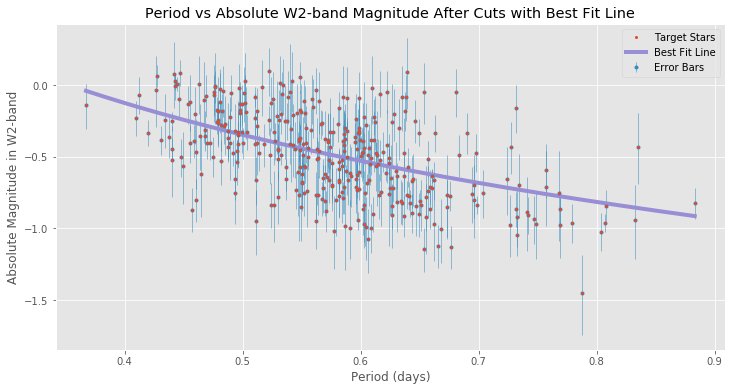

In [452]:
plt.plot(new_pf[new_ind], new_w_abs_mag[new_ind], '.', markersize=4, zorder= 10, label='Target Stars')
plt.errorbar(new_pf[new_ind], new_w_abs_mag[new_ind], xerr=None, yerr=(err_lo, err_hi), fmt = '.', elinewidth = .5, label='Error Bars')
plt.plot(t, M, linewidth=4, label='Best Fit Line')
plt.title('Period vs Absolute W2-band Magnitude After Cuts with Best Fit Line')
plt.ylabel('Absolute Magnitude in W2-band')
plt.xlabel('Period (days)')
plt.legend();

$\text{My likelihood function is:} 
\\ \text{ln} \ p(M_{W2} \ | \ P, \sigma, a, b, f) \ = \ -\frac{1}{2} \sum_n{\Bigg[ \frac{({M_{W2}}_n \ - a \ \text{ln}(P_n) \ - \ b)^2} {s_n^2} \ + \ \text{ln} \Big( 2\pi \ s_n^2 \Big) \Bigg]} \\
\text{where} \\ s_n^2 \ = \ \sigma_n^2 \ + \ f^2 \ (a \ \text{ln} (P_n) \ + b)^2$

In [453]:
pos = soln.x + 1e-4*np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(new_pf[new_ind], new_w_abs_mag[new_ind], err_hi))
sampler.run_mcmc(pos, 1500, progress=True);

100%|██████████| 1500/1500 [01:50<00:00, 14.05it/s]


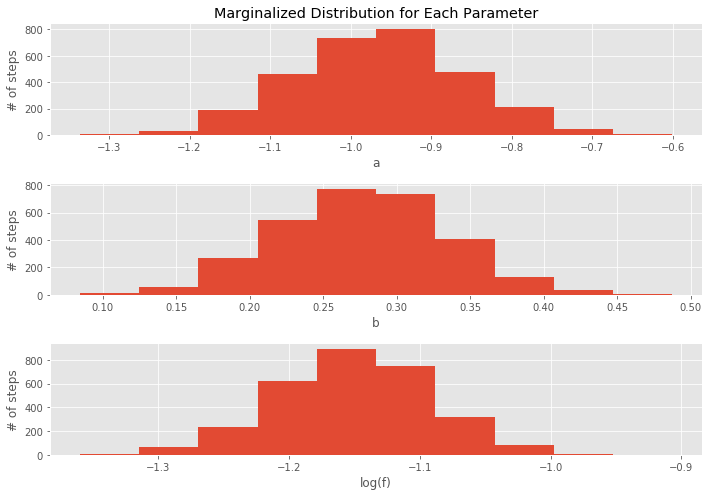

In [454]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=False)
labels = ["a", "b", "log(f)"]
for i in range(3):
    ax = axes[i]
    ax.hist(flat_samples[:, i])
    ax.set_ylabel('# of steps')
    ax.set_xlabel(labels[i])

axes[-3].set_title('Marginalized Distribution for Each Parameter')
plt.tight_layout();

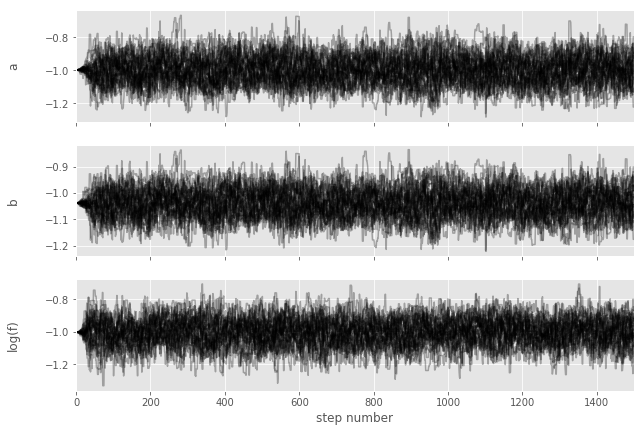

In [455]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
axes[-1].set_xlabel("step number");

I can look at the plots and, again, rationalize that they have converged.

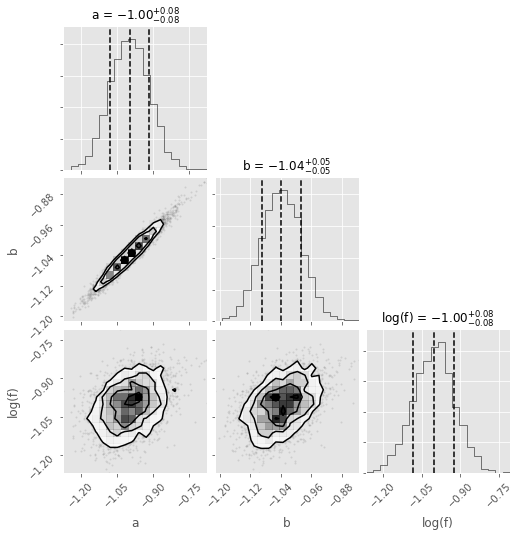

In [456]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels, truths=[a_true, b_true, np.log(f_true)],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12});

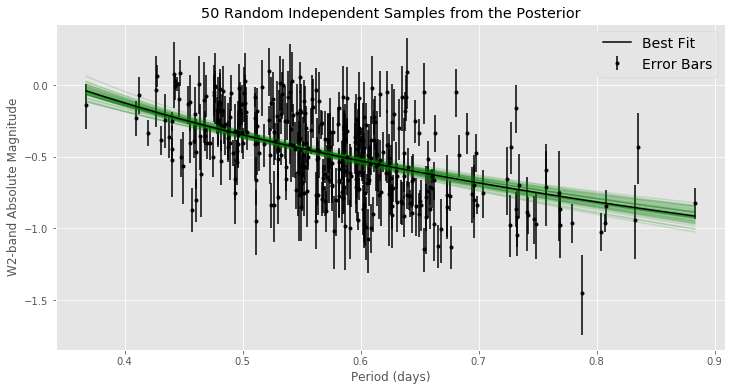

In [457]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
xl = np.array([min(new_pf[new_ind]), max(new_pf[new_ind])])

for a, b, lnf in samples[np.random.randint(len(samples), size=50)]:
    plt.plot(t, a*np.log(t)+b, color="g", alpha=0.15)

plt.errorbar(new_pf[new_ind], new_w_abs_mag[new_ind], yerr = (err_lo, err_hi), fmt=".k", capsize=0, label='Error Bars')
plt.plot(t, M_W2(t), "k", label="Best Fit")
plt.legend(fontsize=14)
plt.xlabel("Period (days)")
plt.ylabel("W2-band Absolute Magnitude")
plt.title('50 Random Independent Samples from the Posterior');

The spread is consistent with what I would expect, considering that the 50 samples seem to be centered around the best fit line, which makes sense since the best fit is the optimal parameters from the posterior distribution. After many tests I finally was able to make this plot work after making sure that the bounds on the priors in the log_prior function allowed the walkers to find the right path along the posterior.

For the optical relation, using the model a * ln(P) + b, my median parameters were a = -0.971, b = 0.273. While for the near-IR relation the median parameters were a = -1.001, b = -1.044. So, as the period increases, I would expect to see that the luminosity of the star increases at a slightly larger rate in the W2, or near-IR band, compared to the G, or optical band. This difference is very marginal though. In gerneral, the stars in my cross match are generally more luminous in near-IR wavelengths compared to optical. The difference in absolute magnitudes for the highest and lowest magnitudes for near-IR and optical fits respectively are 0.873 M_W2 and 0.852 M_G, so the W2-band relation has a slightly larger expected change in the absolute magnitude over our period range compared to the G-band.


From Beaton et al. 2018, they have a W2-band relation of $M_{W2} = -2.540 (\pm 0.248) \ \text{log} \ P + 10.182 (\pm 0.249)$ which is vastly different from my results of $M_{W2} = -1.001 \ \text{log} \ P - 1.044$, as their slope is about a factor of 2.5 off from mine and their y-intercept is an order of magnitude larger than mine. For the G-band, I have $M_{G} = -0.971 \ \text{log} \ + 0.273$ while for their V-band relation they have $M_{V} = -2.07 \ \text{log} \ P + 19.01$. While their slope is only about a factor of two off from my slope estimate, their y-intercept is extremely large compared two mine, by more than an order of magnitude. Beaton et al 2018 used the OGLE survey to get their stellar variation data for the V-band instead of GAIA which may be systematic a cause for some of the differences that our models have. They also removed pW stars, whereas I did no such cuts bassed on stellar classification. For the near-IR band, they looked at M4 and had to use a combination of MIR data and NIR data, and used a Fourier fitting technique and GLOESS method from Monson et al. 2017 to calculate the mean intensity magnitudes, which is different from magnitude calculations that GAIA uses for their catalog, which may account for some of the differences is our models.

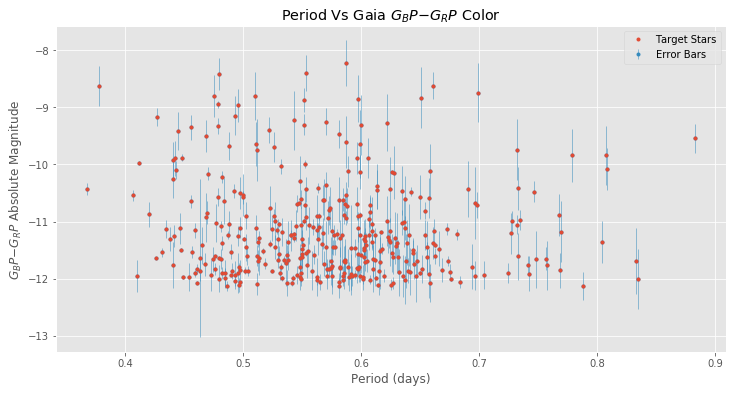

In [86]:
bp_rp_abs_mag = -5 * np.log10(n['r_est'] / 10) + n['bp_rp']
rp_error = (-5 * np.log10(n['r_est'] / 10) + n['phot_rp_mean_mag'] / n['phot_rp_mean_flux_over_error']) 
bp_error = (-5 * np.log10(n['r_est'] / 10) + n['phot_bp_mean_mag'] / n['phot_bp_mean_flux_over_error']) 
bp_rp_error = abs(bp_rp_abs_mag - (rp_error + bp_error) / 2)

plt.plot(n['pf'], bp_rp_abs_mag, '.', label='Target Stars', zorder=10)
plt.errorbar(n['pf'], bp_rp_abs_mag, yerr=bp_rp_error, fmt = '.', elinewidth = .5, label='Error Bars')
plt.title('Period Vs Gaia $G_BP − G_RP$ Color')
plt.xlabel('Period (days)')
plt.ylabel('$G_BP − G_RP$ Absolute Magnitude')
plt.legend();

In [107]:
# guess params
a_true = -2
b_true = -10
f_true = 1.7057

def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * np.log(x) + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprior(theta):
    a, b, lnf = theta
    if -2 < a < 0 and -15 < b < 3.5 and -5.0 < lnf < 1.0:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

from scipy.optimize import minimize
nll = lambda *args: -lnlike(*args)
initial = np.array([a_true, b_true, np.log(f_true)]) + 0.1*np.random.randn(3)
soln = minimize(nll, initial, args=(n['pf'], bp_rp_abs_mag, bp_rp_error))
a_ml, b_ml, log_f_ml = soln.x

print(f'My estimated parameters for the model: a * np.log(x) + b, are a = {a_ml}, b = {b_ml} \nwith a log likelihood of {log_f_ml}')


My estimated parameters for the model: a * np.log(x) + b, are a = -0.5546284364765476, b = -11.479630481222204 
with a log likelihood of -2.6707889052708254


In [108]:
def M_bp_rp(P):
    return a_ml * np.log(P) + b_ml

t = np.linspace(min(n['pf']), max(n['pf']), 250)
M = M_bp_rp(t)

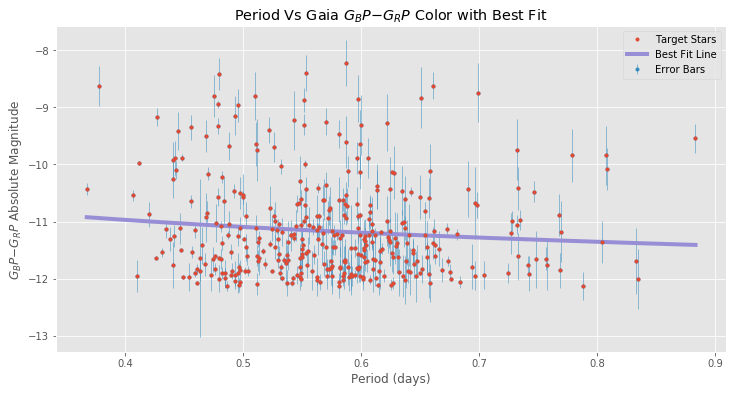

In [109]:
plt.plot(n['pf'], bp_rp_abs_mag, '.', label='Target Stars', zorder=10)
plt.errorbar(n['pf'], bp_rp_abs_mag, yerr=bp_rp_error, fmt = '.', elinewidth = .5, label='Error Bars')
plt.plot(t, M, linewidth=4, label='Best Fit Line')
plt.title('Period Vs Gaia $G_BP − G_RP$ Color with Best Fit')
plt.xlabel('Period (days)')
plt.ylabel('$G_BP − G_RP$ Absolute Magnitude')
plt.legend();

$\text{Thus, my model between log(period) and the Gaia} \ G_{BP} − G_{RP} \ \text{color is:} \\ 
(G_{BP} − G_{RP}) \ = \ -0.55 \ \text{log}(P) \ - \ 11.48 \\
\text{Further details below.}$

In [111]:
pos = soln.x + 1e-4*np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(n['pf'], bp_rp_abs_mag, bp_rp_error))
sampler.run_mcmc(pos, 1500, progress=True)
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True);

100%|██████████| 1500/1500 [02:06<00:00, 11.86it/s]


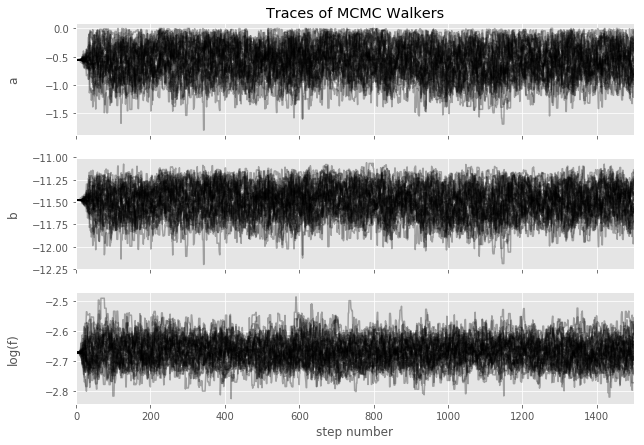

In [115]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-3].set_title('Traces of MCMC Walkers')
axes[-1].set_xlabel("step number");

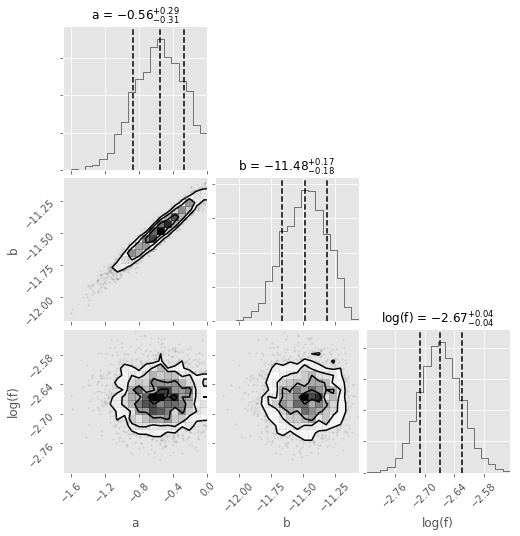

In [113]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels, truths=[a_true, b_true, np.log(f_true)],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12});

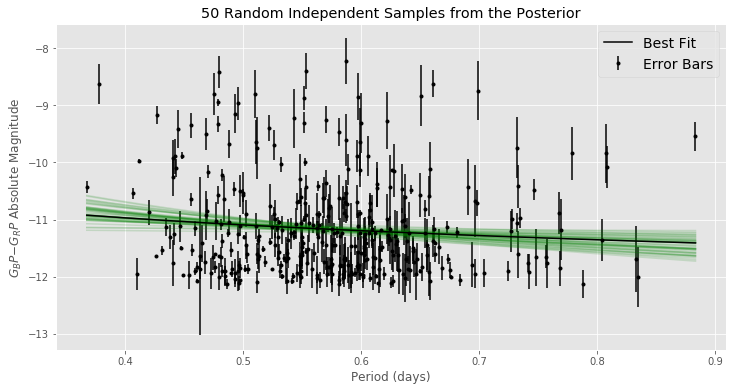

In [118]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

for a, b, lnf in samples[np.random.randint(len(samples), size=50)]:
    plt.plot(t, a*np.log(t)+b, color="g", alpha=0.15)

plt.errorbar(n['pf'], bp_rp_abs_mag, bp_rp_error, fmt=".k", capsize=0, label='Error Bars')
plt.plot(t, M_bp_rp(t), "k", label="Best Fit")
plt.legend(fontsize=14)
plt.xlabel("Period (days)")
plt.ylabel('$G_BP − G_RP$ Absolute Magnitude')
plt.title('50 Random Independent Samples from the Posterior');